1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [1]:
import numpy as np 
import pandas as pd
import scipy.stats
import scipy.linalg
import matplotlib.pyplot as plt

In [2]:
# I'll recycle the NormGenerator class that I've built in 06ex
class NormGenerator:
    """this class generates 1D-normal distributions"""

    # constructor
    def __init__(
        self, 
        mu: float, 
        sigma: float = None, 
        size: int = 1000
    ) -> None:
        
        if sigma <= 0:
            sigma = np.abs(sigma)
        
        # store parameters
        self.mu:      float = mu
        self.sigma:   float = sigma
        self.size:    int   = size

    # generate sample
    def generate_sample(self) -> np.ndarray:
        return scipy.stats.norm.rvs(loc=self.mu, scale=self.sigma, size=self.size )

In [46]:
N = 5000

x_1 = NormGenerator(0, 1, N).generate_sample()
x_2 = x_1 + NormGenerator(0, 3, N).generate_sample()
x_3 = 2*x_1 + x_2

dataset = np.array([x_1,x_2,x_3])

dataset.shape

(3, 5000)

In [105]:
C = np.cov(dataset)
cols, rows = np.shape(dataset)

print(f"The dataset has {rows} rows and {cols} cols.")
print()
print(f"The covariance matrix of the dataset is of shape {np.shape(C)}")

l, V = scipy.linalg.eig(C)
l = np.real_if_close(l)

print("\n\n")
print("Using Eigendecomposition:")
print(f"Eigenvalues:  {l}")
print(f"Eigenvectors: \n{V}")


U, spectrum, Vt = scipy.linalg.svd(dataset)

#data has zero mean so XX.T is the scaled cov matrix
l_svd = np.real_if_close(spectrum)**2/(N-1)
V_svd = U


print("\n\n")
print("Using SVD:")
print(f"Eigenvalues: {l_svd}")
print(f"Eigenvectors: \n{V_svd}")

The dataset has 5000 rows and 3 cols.

The covariance matrix of the dataset is of shape (3, 3)



Using Eigendecomposition:
Eigenvalues:  [ 2.66973071e+01 -6.38613480e-16  2.05520885e+00]
Eigenvectors: 
[[-0.11497833 -0.81649658  0.56578558]
 [-0.57796465 -0.40824829 -0.70660469]
 [-0.80792131  0.40824829  0.42496646]]



Using SVD:
Eigenvalues: [2.67025049e+01 2.05529552e+00 3.35276216e-32]
Eigenvectors: 
[[-0.11496292  0.56578871 -0.81649658]
 [-0.5779839  -0.70658895 -0.40824829]
 [-0.80790974  0.42498846  0.40824829]]


In [106]:
# A = VLV^T eigen decomposition definition
# in this case, A is the covariance matrix C of the dataset

# check for eigendecomposition of C
D = np.dot(V, np.dot(np.diag( np.real_if_close(l) ), V.T))

# check for SVD of dataset
E = np.dot(V_svd, np.dot(np.diag( np.real_if_close(l_svd) ), V_svd.T))

print("\nCovariance matrix:\n", C)
print("Reconstructed C after eigendecomposition:\n", D)
print("Reconstructed C after SVD:\n", E)

print("\n\nThe two methods do lead to the same results, though they differ a bit due to numerical approximations:\n")
print(f"C = D: {np.allclose(C, D, atol=1e-2)}")
print(f"C = E: {np.allclose(C, E, atol=1e-2)}")


Covariance matrix:
 [[ 1.01083856  0.95248184  2.97415896]
 [ 0.95248184  9.94419789 11.84916157]
 [ 2.97415896 11.84916157 17.79747948]]
Reconstructed C after eigendecomposition:
 [[ 1.01083856  0.95248184  2.97415896]
 [ 0.95248184  9.94419789 11.84916157]
 [ 2.97415896 11.84916157 17.79747948]]
Reconstructed C after SVD:
 [[ 1.01084769  0.95262763  2.97432301]
 [ 0.95262763  9.94652574 11.85178101]
 [ 2.97432301 11.85178101 17.80042703]]


The two methods do lead to the same results, though they differ a bit due to numerical approximations:

C = D: True
C = E: True


In [133]:
############ PCA

L = np.diag(l)
tr_L = L.trace()

# we want to keep at least 99% of the variability
# thus we need to choose the right amount of features 
# we will sum the eigenvalues until we reach 99% of the trace

th = 0.99*tr_L 

sum_li = 0  
for i, li in enumerate(np.flip(np.sort(l))):
    sum_li += li
    if sum_li >= th:
        i += 1
        break

print(f"The number of features that retain th 99% of the total variability are {i}")
print()
print("The contributions of the three features to the eigenvalues of the cov_matrix are the following:")
print(f"1: {np.abs(l[0]) / tr_L * 100:.2f }%")
print(f"2: {np.abs(l[1]) / tr_L * 100:.16f}%")
print(f"3: {np.abs(l[2]) / tr_L * 100:.2f }%")
print()
print(f"Thus, we expect that feature 1 and 3 account for the {(np.abs(l[0]) + np.abs(l[2]))*100/tr_L:.1f}% of the variability (well, should be something like 99.9999999999999%)")

The number of features that retain th 99% of the total variability are 2

The contributions of the three features to the eigenvalues of the cov_matrix are the following:
1: 92.85%
2: 0.0000000000000022%
3: 7.15%

Thus, we expect that feature 1 and 3 account for the 100.0% of the variability (well, should be something like 99.9999999999999%)


In [258]:
rotated_dataset = np.dot(V.T, dataset)                          # rotated dataset
reduced_dataset = np.delete(rotated_dataset,  np.argmin(l), 0)  # reduced dataset

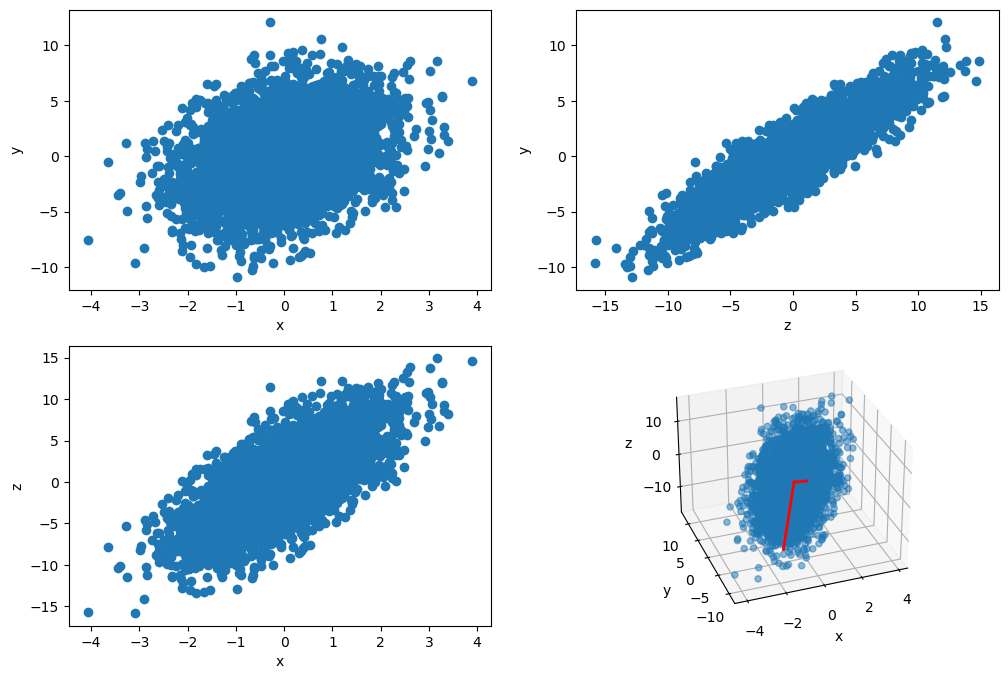

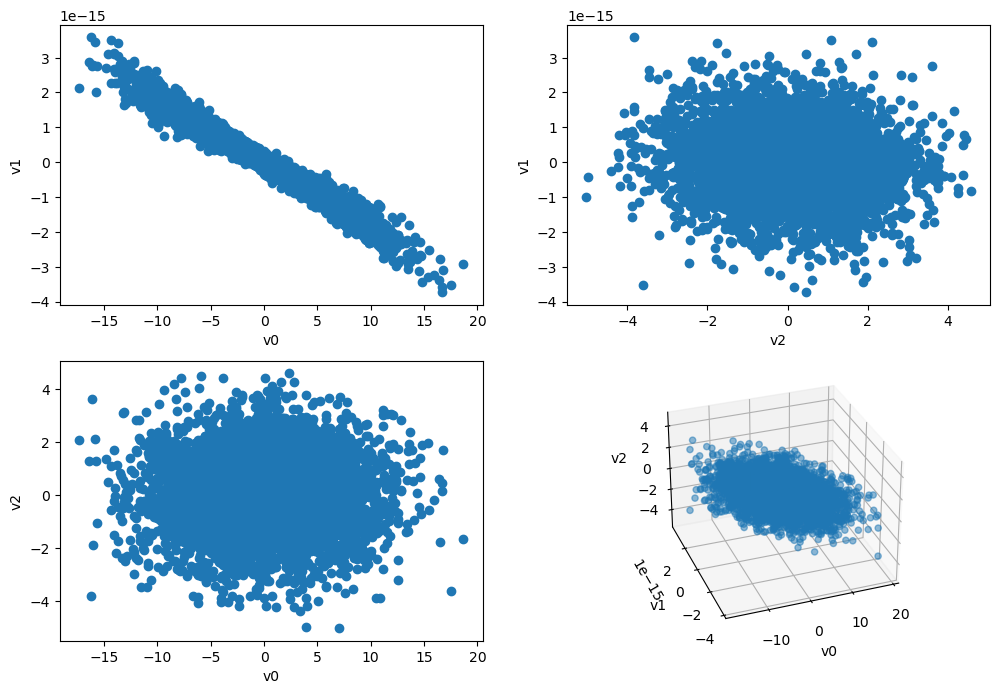

In [274]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (12,8))

ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(dataset[0], dataset[1])
ax1.set_xlabel("x")
ax1.set_ylabel("y")
    
ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(dataset[2], dataset[1])
ax2.set_xlabel("z")
ax2.set_ylabel("y")

ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(dataset[0], dataset[2])
ax3.set_xlabel("x")
ax3.set_ylabel("z")

ax4 = fig.add_subplot(2, 2, 4, projection='3d')

ax4.scatter(dataset[0], dataset[1], dataset[2], alpha=0.5)

for li, vi in zip(l, V.T):
    ax4.plot([0, .5*li*vi[0]], [0, .5*li*vi[1]], [0, .5*li*vi[2]], 'r-', lw=2, zorder=10)
    
ax4.view_init(elev = 30, azim = 250)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_zlabel("z")
for spine in ax4.spines.values():
    spine.set_visible(False)

plt.show()



fig = plt.figure(figsize = (12,8))

ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(rotated_dataset[0], rotated_dataset[1])
ax1.set_xlabel("v0")
ax1.set_ylabel("v1")
    
ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(rotated_dataset[2], rotated_dataset[1])
ax2.set_xlabel("v2")
ax2.set_ylabel("v1")

ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(rotated_dataset[0], rotated_dataset[2])
ax3.set_xlabel("v0")
ax3.set_ylabel("v2")

ax4 = fig.add_subplot(2, 2, 4, projection='3d')

ax4.scatter(rotated_dataset[0], rotated_dataset[1], rotated_dataset[2], alpha=0.5)
    
ax4.view_init(elev = 30, azim = 250)
ax4.set_xlabel("v0")
ax4.set_ylabel("v1")
ax4.set_zlabel("v2")
for spine in ax4.spines.values():
    spine.set_visible(False)

plt.show()

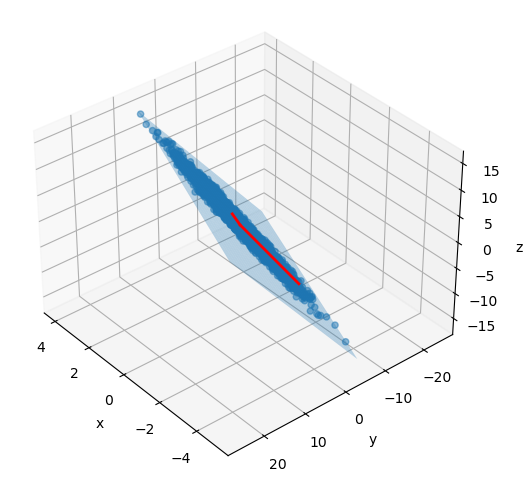

In [253]:
fig = plt.figure(figsize=(7,6))

v1, v2, v3 = V.T
xx, zz = np.meshgrid(range(-5, 5), range(-16, 16))
y = (-v2[0] * xx - v2[2] * zz ) * 1. / v2[1]

ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(xx, y, zz, alpha=0.3)
ax.scatter(dataset[0], dataset[1], dataset[2], alpha=0.5)

for li, vi in zip(l, V.T):
    ax.plot([0, .5*li*vi[0]], [0, .5*li*vi[1]], [0, .5*li*vi[2]], 'r-', lw=2, zorder=10)
    
ax.view_init(elev = 35, azim = 140)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 